<a href="https://colab.research.google.com/github/mattiasthalen/Bayesian-Velocity-Profiling/blob/main/Bayesian_Velocity_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Velocity Profiling

## Setup Environment


### Load Libraries

In [1]:
import time
import pint_xarray
import warnings
import os

import sklearn.preprocessing
import sklearn.metrics

import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import xarray as xr

from collections import OrderedDict
from urllib.parse import unquote

from urllib.parse import unquote
from matplotlib import pyplot as plt

from typing import Callable, Optional, Dict, List, Union, NoReturn

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Set Global Vars

In [2]:
hdi_prob = 0.9
csv_path = 'https://raw.githubusercontent.com/mattiasthalen/Bayesian-Velocity-Profiling/main/RepOne_Data_Export.csv'
plt.style.use('bmh')

## Functions

### Miscellaneous Functions

In [3]:
def assign_set_type(da, **kwargs):
    set_category = xr.where(da['set'] < da.idxmax('set'), 'Work Up', np.nan)
    set_category = xr.where(da['set'] == da.idxmax('set'), 'Top Set', set_category)
    set_category = xr.where(da['set'] > da.idxmax('set'), 'Back Off', set_category)
    set_category = xr.where(np.isnan(da), np.nan, set_category)
    
    return set_category

In [4]:
def agg_summarize(x, **kwargs):
    x = x[np.isfinite(x)]

    if len(x) > 0:
        min = np.min(x)
        max = np.max(x)
        first = x[0]
        last = x[-1]
        peak_end = np.mean([min, last])
        mean = np.mean(x)
        median = np.median(x)
        hdi = az.hdi(x)
        result = np.array([min, max, first, last, peak_end, mean, median, *hdi])
    else:
        result = np.array([np.nan]*9)
    
    return result

def summarize(x, reduce_dim = 'rep', **kwargs):
    summaries = xr.apply_ufunc(agg_summarize,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['aggregation']])
    
    summaries['aggregation'] = ['min', 'max', 'first', 'last', 'peak_end', 'mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

In [5]:
def agg_hdi_summary(x, **kwargs):
    mean = x.mean()
    median = np.median(x)
    hdi = az.hdi(x)

    return np.array([mean, median, *hdi])

def hdi_summary(x, reduce_dim = 'sample', **kwargs):
    try:
        x = x.pint.dequantify()
    except:
        pass

    summaries = xr.apply_ufunc(agg_hdi_summary,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['hdi_aggregation']])
    
    summaries['hdi_aggregation'] = ['mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

In [6]:
def all_nan_summary(x, mode = 'mean', **kwargs):
    if np.all(np.isnan(x)):
        return np.nan
    elif mode == 'max':
        return np.nanmax(x)
    elif mode == 'min':
        return np.nanmin(x)
    elif mode == 'mean':
        return np.nanmean(x)
    elif mode == 'sum':
        return np.nansum(x)
        
def all_nan_max(x, **kwargs):
    return all_nan_summary(x, 'max', **kwargs)
        
def all_nan_min(x, **kwargs):
    return all_nan_summary(x, 'min', **kwargs)
        
def all_nan_mean(x, **kwargs):
    return all_nan_summary(x, 'mean', **kwargs)
        
def all_nan_sum(x, **kwargs):
    return all_nan_summary(x, 'sum', **kwargs)

### ETL Functions

In [7]:
def csv_to_dataframe(csv_path, **kwargs):
    df = pd.read_csv(csv_path)

    df.columns = (df.columns
                    .str.lower()
                    .str.replace(' \(m/s\)', '', regex = True)
                    .str.replace(' \(mm\)', '', regex = True)
                    .str.replace(' \(sec\)', '', regex = True)
                    .str.replace(' \(%\)', '', regex = True)
                    .str.replace(' ', '_', regex = True))
        
    df.rename(columns = {'weight': 'load'}, inplace = True)

    df['workout_start_time'] = pd.to_datetime(df['workout_start_time'], format = '%d/%m/%Y, %H:%M:%S')

    df.dropna(subset = ['exercise'], inplace = True)
    df['rest_time'] = pd.to_timedelta(df['rest_time'])

    # Correct split session
    df['set'].mask((df['exercise'] == 'deadlift') & (df['workout_start_time'] == pd.to_datetime('2020-12-30 13:06:04')), df['set'] + 7, inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2020-12-30 13:06:04')}, pd.to_datetime('2020-12-30 12:53:09'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-01-07 11:50:22')}, pd.to_datetime('2021-01-07 11:20:07'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-10 12:02:22')}, pd.to_datetime('2021-06-10 11:56:31'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-14 12:06:00')}, pd.to_datetime('2021-06-14 11:57:50'), inplace = True)

    # Reindex sets & reps to counter bugs in the extract
    df['set'] = df.groupby(['exercise', 'workout_start_time'])['set'].apply(lambda x: (x != x.shift()).cumsum() - 1)
    df['rep'] = df.groupby(['exercise', 'workout_start_time', 'set']).cumcount()

    # Convert from , to . as decimal sign
    df['load'] = df['load'].str.replace(',', '.').astype('float')

    # Drop rows with tag fail
    fail_filter = df['tags'].str.contains('fail', na = False)
    df = df[~fail_filter]

    # Handle the case when a rep is split into two reps
    rep_split_filter = df['tags'].str.contains('rep split', na = False)

    rep_split_df = df[rep_split_filter].groupby(['exercise', 'workout_start_time', 'set', 'load', 'metric'])[['range_of_motion', 'duration_of_rep']].sum()
    rep_split_df['avg_velocity'] = rep_split_df['range_of_motion']/1000/rep_split_df['duration_of_rep']
    rep_split_df['rep'] = 0
    rep_split_df.reset_index(inplace = True)

    rep_split_df = rep_split_df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    df = pd.concat([df[~rep_split_filter], rep_split_df])

    # Group to get multi index
    df = df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    return df

In [8]:
def dataframe_to_dataset(df, **kwargs):
    # Convert to xarray
    ds = df.to_xarray()

    # Change Set and Rep to integers
    ds['set'] = ds['set'].astype(int)
    ds['rep'] = ds['rep'].astype(int)

    # Move variables to coords
    ds = ds.set_coords(['metric', 'tags'])

    # Define UOMs
    ds = ds.pint.quantify({'load': 'kg',
                            'avg_velocity': 'meter / second',
                            'peak_velocity': 'meter / seconds',
                            'range_of_motion': 'mm',
                            'duration_of_rep': 's'})

    # Session meta data
    session_stack = ['exercise', 'workout_start_time']
    ds['session_max_load'] = ds['load'].stack(stack = session_stack)\
                                        .groupby('stack')\
                                        .reduce(all_nan_max, ...)\
                                        .unstack()

    # Set meta data
    set_stack = [*session_stack, 'set']
    ds['load'] = (ds['load'].stack(stack = set_stack)
                            .groupby('stack')
                            .reduce(all_nan_max, ...)
                            .unstack())

    ds['reps'] = (ds['avg_velocity'].stack(stack = set_stack)
                                    .groupby('stack')
                                    .count(...)
                                    .unstack()
                                    .where(ds['load'] > 0, drop = True))

    ds['set_velocities'] = summarize(ds['avg_velocity'].pint.dequantify())
    ds['set_velocities'] = ds['set_velocities'].pint.quantify({ds['set_velocities'].name: 'mps'})

    ds.coords['set_type'] = assign_set_type(ds['load'])

    # Add the running min top set velocity per exercise
    ds['minimum_velocity_threshold'] = (ds['set_velocities'].sel({'aggregation': 'first'})
                                                            .where(ds.coords['set_type'] == 'Top Set')
                                                            .pint.dequantify()
                                                            .stack(stack = session_stack)
                                                            .groupby('stack')
                                                            .reduce(all_nan_min, ...)
                                                            .unstack()
                                                            .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                                    min_periods = 1)
                                                            .min())
    ds['minimum_velocity_threshold'] = ds['minimum_velocity_threshold'].pint.quantify({ds['minimum_velocity_threshold'].name: 'meter / second'})

    # Add running max load per exercise
    ds['rolling_max_load'] = (ds['load'].pint.dequantify()
                                        .stack(stack = session_stack)
                                        .groupby('stack')
                                        .reduce(all_nan_max, ...)
                                        .unstack()
                                        .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                min_periods = 1)
                                        .max())
    ds['rolling_max_load'] = ds['rolling_max_load'].pint.quantify({ds['rolling_max_load'].name: 'kg'})

    # Additional session meta data
    ds['workup_sets'] = ds['load'].where(ds.coords['set_type'] == 'Work Up', drop = True)\
                                    .stack(stack = session_stack)\
                                    .groupby('stack')\
                                    .count(...)\
                                    .unstack()

    #ds['session_regression_coefficients'] = linear_fit(ds, 'load', 'set_velocities', 'set')

    #ds['estimated_1rm'] = linear_predict(ds['minimum_velocity_threshold'].pint.dequantify(), ds['session_regression_coefficients'])
    #ds['estimated_1rm'] = ds['estimated_1rm'].pint.quantify({ds['estimated_1rm'].name: 'kg'})

    #ds['zero_velocity_load'] = linear_predict(0, ds['session_regression_coefficients'])
    #ds['zero_velocity_load'] = ds['zero_velocity_load'].pint.quantify({ds['zero_velocity_load'].name: 'kg'})

    #ds['zero_load_velocity'] = linear_predict(0, ds['session_regression_coefficients'], reverse = True)
    #ds['zero_load_velocity'] = ds['zero_load_velocity'].pint.quantify({ds['zero_load_velocity'].name: 'mps'})

    #ds['curve_score'] = ds['zero_velocity_load'].pint.dequantify()*ds['zero_load_velocity'].pint.dequantify()/2

    ds['session_volume'] = (ds['load'] * ds['reps']).stack(stack = session_stack).groupby('stack').sum(...).unstack()
    #ds['session_relative_volume'] = ds['session_volume']/ds['estimated_1rm']

    # Rep meta data
    #ds['rep_exertion'] = linear_predict(ds['avg_velocity'].pint.dequantify(), ds['session_regression_coefficients'])/ds['estimated_1rm'].pint.dequantify()
    #ds['rep_force'] = (ds['load']*ds['range_of_motion'].pint.to('meter')/ds['duration_of_rep']**2).pint.to('N')
    #ds['rep_energy'] = (ds['rep_force']*ds['range_of_motion'].pint.to('meter')).pint.to('J')

    # Session meta data
    #ds['session_exertion_load'] = ds['rep_exertion'].stack(stack = ['exercise', 'workout_start_time']).groupby('stack').reduce(all_nan_sum, ...).unstack().pint.dequantify()

    # Add PR coordinates
    ds.coords['max_load_pr_flag'] = ds['rolling_max_load'].diff('workout_start_time') > 0
    ds.coords['max_load_pr_flag'] = ds.coords['max_load_pr_flag'].fillna(0).astype(int)

    # Add indexing for inference
    session_shape = [ds.dims[i] for i in session_stack]
    ds.coords['session'] = (session_stack, np.arange(np.prod(session_shape)).reshape(session_shape))

    observation_shape = [ds.dims[i] for i in set_stack]
    ds.coords['observation'] = (set_stack, np.arange(np.prod(observation_shape)).reshape(observation_shape))

    return ds

In [9]:
def load_data(csv_path, **kwargs):
    df = csv_to_dataframe(csv_path, **kwargs)
    ds = dataframe_to_dataset(df, **kwargs)

    return ds

In [10]:
def extract_regression_data(ds, **kwargs):
    df = (ds[['load', 'set_velocities', 'observation', 'session']]
                .pint.dequantify()
                .sel({'aggregation': 'max'}, drop = True)
                .where(ds.coords['set_type'] != 'Back Off')
                .where(ds.coords['exercise'] != 'front squat')
                .drop_vars(['set_type', 'max_load_pr_flag'])
                .to_dataframe()
                .dropna()
                .reset_index()
                .drop(['set', 'workout_start_time'], axis = 1)
                .rename(columns = {'set_velocities': 'velocity'}))

    # Scale data to simplify inference
    velocity_standardizer = sklearn.preprocessing.StandardScaler()
    df['velocity_std'] = velocity_standardizer.fit_transform(df['velocity'].values.reshape(-1, 1))

    load_standardizer = sklearn.preprocessing.StandardScaler()
    df['load_std'] = load_standardizer.fit_transform(df['load'].values.reshape(-1, 1))


    return [df, velocity_standardizer, load_standardizer]


In [11]:
def extract_model_data(df):
    velocity_std = df['velocity_std'].values
    load_std = df['load_std'].values

    observation = df['observation'].values

    exercises = df['exercise'].values
    exercise_encoder = sklearn.preprocessing.LabelEncoder()
    exercise_encoder.fit(exercises)

    sessions = df['session'].values
    session_encoder = sklearn.preprocessing.LabelEncoder()
    observation_session_idx = session_encoder.fit_transform(sessions)

    session_exercise = (df.reset_index()[['session', 'exercise']]
                        .drop_duplicates()
                        .set_index('session', verify_integrity = True)
                        .sort_index()['exercise']
                        .values)

    session_exercise_idx = exercise_encoder.transform(session_exercise)

    # Needs to be in order from observation and up to global
    coords = {'observation': observation,
              'session': session_encoder.classes_,
              'exercise': exercise_encoder.classes_}

    model_data = {'velocity_std': velocity_std,
                  'load_std': load_std,
                  'observation_session_idx': observation_session_idx,
                  'session_exercise_idx': session_exercise_idx,
                  'coords': coords}
    
    return [model_data, session_encoder, exercise_encoder]

In [12]:
def generate_prediction_data(df, velocity_standardizer):
    velocity_min = 0
    velocity_max = np.ceil(df['velocity'].max()*10)/10
    velocity_round = 0.01
    velocity_pred = np.linspace(velocity_max, velocity_min, int(velocity_max/velocity_round) + 1).round(2)
    
    prediction_df = pd.DataFrame()

    for i in df['session'].unique():
        session = np.full_like(velocity_pred, i).astype(int)
        new_data = pd.DataFrame({'velocity': velocity_pred,
                                'session': session})
        
        prediction_df = pd.concat([prediction_df, new_data])

    prediction_df['velocity_std'] = velocity_standardizer.transform(prediction_df['velocity'].values.reshape(-1, 1))

    prediction_df = prediction_df.merge(df[['velocity', 'exercise', 'session', 'load_std', 'observation']], on = ['velocity', 'session'], how = 'left')

    last_observation = prediction_df['observation'].max()
    observation = []

    for i in prediction_df['observation']:

        obs = i

        if i >= 0:
            obs = i
        else:
            obs = last_observation + 1
            last_observation = obs
        
        observation.append(obs)

    prediction_df['observation'] = np.array(observation).astype(int)

    return prediction_df

### Model Functions

In [13]:
def build_model(velocity_std,
                load_std,
                observation_session_idx,
                session_exercise_idx,
                coords,
                render_model = True,
                **kwargs):

    with pm.Model() as model:
        
        # Add coordinates
        model.add_coord(name = 'observation',
                        values = coords['observation'],
                        mutable = True)
        
        model.add_coord(name = 'session',
                        values = coords['session'],
                        mutable = True)
        
        model.add_coord(name = 'exercise',
                        values = coords['exercise'],
                        mutable = True)

        # Add inputs
        velocity_std = pm.MutableData(name = 'velocity_std',
                                      value = velocity_std,
                                      dims = 'observation')

        load_std = pm.MutableData(name = 'load_std',
                                  value = load_std,
                                  dims = 'observation')

        observation_session_idx = pm.MutableData(name = 'observation_session_idx',
                                                 value = observation_session_idx,
                                                 dims = 'observation')

        session_exercise_idx = pm.MutableData(name = 'session_exercise_idx',
                                              value = session_exercise_idx,
                                              dims = 'session')

        # Global Parameters
        global_intercept = pm.Normal(name = 'global_intercept',
                                     mu = 0.0,
                                     sigma = 1.0)

        global_trend = pm.HalfNormal(name = 'global_trend',
                                     sigma = 1.0)
        
        global_curve = pm.HalfNormal(name = 'global_curve',
                                     sigma = 1.0)
        
        # Exercise Parameters
        dim2_intercept = pm.Normal(name = 'exercise_intercept',
                                   mu = global_intercept,
                                   sigma = 1.0,
                                   dims = 'exercise')

        dim2_trend = pm.HalfNormal(name = 'exercise_trend',
                                   sigma = global_trend,
                                   dims = 'exercise')
        
        dim2_curve = pm.HalfNormal(name = 'exercise_curve',
                                   sigma = global_curve,
                                   dims = 'exercise')

        # Session Parameters
        dim1_intercept = pm.Normal(name = 'session_intercept',
                                   mu = dim2_intercept[session_exercise_idx],
                                   sigma = 1.0,
                                   dims = 'session')

        dim1_trend = pm.HalfNormal(name = 'session_trend',
                                   sigma = dim2_trend[session_exercise_idx],
                                   dims = 'session')

        dim1_curve = pm.HalfNormal(name = 'session_curve',
                                   sigma = dim2_curve[session_exercise_idx],
                                   dims = 'session')
        
        # Final Parameters
        intercept = dim1_intercept[observation_session_idx]
        trend = dim1_trend[observation_session_idx]
        curve = dim1_curve[observation_session_idx]

        # Estimated Value
        sigma = pm.HalfNormal(name = 'sigma',
                              sigma = 1.0)

        mu = pm.Deterministic(name = 'mu',
                              var = intercept - trend*velocity_std - curve*velocity_std**2,
                              dims = 'observation')

        # Likelihood
        likelihood = pm.Normal(name = 'likelihood',
                               mu = mu,
                               sigma = sigma,
                               observed = load_std,
                               dims = 'observation')
        
    if render_model:
        display(pm.model_to_graphviz(model))
        
    return model

In [14]:
def sample_pymc_nuts(model,
                     prior_predictive = True,
                     posterior_predictive = True,
                     **kwargs):
    with model:
        print('Sample posterior...')
        inference_data = pm.sample(**kwargs)
        
        if prior_predictive:
            print('Sample prior predictive...')
            inference_data.extend(pm.sample_prior_predictive())

        if posterior_predictive:
            print('Sample posterior predictive...')
            inference_data.extend(pm.sample_posterior_predictive(trace = inference_data))

    return inference_data

### Plotting Functions

In [15]:
def plot_last_session_predictions(inference_data,
                                  df,
                                  exercises,
                                  hdi_prob = 0.8):
    n_exercises = len(exercises)

    n_rows = np.ceil(n_exercises / 2).astype(int)
    n_cols = n_exercises - n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 10), sharex = True, sharey = True)

    axes = axes.flatten()

    for i, ax in enumerate(axes):

        exercise = exercises[i]

        last_session = df[df['exercise'] == exercise]['session'].max()
        last_session_observations = df[df['session'] == last_session]['observation'].values

        predictions = inference_data.predictions.sel(observation = last_session_observations)
        predictions_constant_data = inference_data.predictions_constant_data.sel(observation = last_session_observations)#, session = last_session, exercise = exercise)

        az.plot_lm(x = predictions_constant_data['velocity_std'],
                   y = predictions_constant_data['load_std'],
                   y_hat = predictions['likelihood'],
                   y_model = predictions['mu'],
                   kind_pp = 'hdi',
                   kind_model = 'hdi',
                   y_kwargs = {'marker': '.',
                               'markersize': 9,
                               'color': '#0571b0',
                               'label': 'Observed Data',
                               'zorder': 3},
                   y_hat_fill_kwargs = {'fill_kwargs': {'zorder': 0,
                                                        'alpha': 0.6},
                                        'color': '#92c5de',
                                        'hdi_prob': hdi_prob},
                   y_model_mean_kwargs = {'zorder': 2,
                                          'color': '#ca0020',
                                          'linewidth': 1,
                                          'linestyle': 'dashed'},
                   y_model_fill_kwargs = {'zorder': 1,
                                          'color': '#f4a582',
                                          'alpha': 0.6,
                                          #'fill_kwargs': {'zorder': 1},
                                          #'hdi_kwargs': {'hdi_prob': hdi_prob}
                                          },
                   legend = False,
                   axes = ax)
                   
        ax.set_title(exercise.title(), fontweight = 'bold')
        ax.set_xlabel('Velocity', fontweight = 'bold')
        ax.set_ylabel('Load', fontweight = 'bold')
        ax.legend(loc = 'upper right')

    fig.suptitle('LAST SESSION PER EXERCISE',
                fontweight = 'bold',
                fontsize = 'x-large')

    plt.draw()

In [16]:
def plot_pbc(ds, exercise, data_var, window = 20, signal_window = 8, ax = None, **kwargs):
    df = ds[data_var].sel({'exercise': exercise}, drop = True)\
                     .drop_vars(['training_cycle', 'cycle_type', 'max_weight_pr_flag'])\
                     .to_dataframe()\
                     .dropna()
    
    df['moving_average'] = df[data_var].sort_index(ascending = False)\
                                       .rolling(window, min_periods = 1)\
                                       .mean()
    
    df['moving_range'] = df[data_var].diff(-1)\
                                     .abs()\
                                     .sort_index(ascending = False)\
                                     .rolling(window, min_periods = 1)\
                                     .mean()

    df['process_average'] = df['moving_average']
    df['process_range'] = df['moving_range']
    df['signal'] = None
    df['signal_min'] = None
    df['signal_max'] = None
    df['signal_above_average'] = None
    df['signal_below_average'] = None

    n_rows = len(df)
    previous_signal_id = 0

    for row in np.arange(n_rows):
        first_row = row == 0
        sufficient_rows_left = n_rows - row >= window

        signal_start_id = np.max([8, row - signal_window])

        df['signal_min'][row] = df[data_var][signal_start_id:row].min()
        df['signal_max'][row] = df[data_var][signal_start_id:row].max()

        df['signal_above_average'][row] = (df['signal_min'][row] > df['process_average'][row - 1])
        df['signal_below_average'][row] = (df['signal_max'][row] < df['process_average'][row - 1])

        signal_open = (first_row) | (row >= previous_signal_id + window)
        signal = (signal_open) & (sufficient_rows_left) & (first_row | df['signal_above_average'][row] | df['signal_below_average'][row])
        df['signal'][row] = signal
        
        df['process_average'][row] =  df['process_average'][row - 1]
        df['process_range'][row] =  df['process_range'][row - 1]

        if signal:
            previous_signal_id = row
            df['process_average'][row] =  df['moving_average'][row]
            df['process_range'][row] =  df['moving_range'][row]
        else:
            df['process_average'][row] =  df['process_average'][row - 1]
            df['process_range'][row] =  df['process_range'][row - 1]

    df['lower_limit_1'] = df['process_average'] - df['process_range']/1.128
    df['upper_limit_1'] = df['process_average'] + df['process_range']/1.128
    df['lower_limit_2'] = df['process_average'] - df['process_range']*2/1.128
    df['upper_limit_2'] = df['process_average'] + df['process_range']*2/1.128
    df['lower_limit_3'] = df['process_average'] - df['process_range']*3/1.128
    df['upper_limit_3'] = df['process_average'] + df['process_range']*3/1.128

    if ax is None:
        ax = plt.gca()

    ax.scatter(df.index, df[data_var], marker = '.', alpha = 0.6)
    ax.plot(df.index, df['process_average'])
    ax.plot(df.index, df['lower_limit_3'])
    ax.plot(df.index, df['upper_limit_3'])

    ax.fill_between(df.index,df['lower_limit_1'], df['upper_limit_1'], alpha = 0.3)

    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_ylim([0, None])
    ax.tick_params(labelrotation = 90)
    ax.grid()

    return ax

In [17]:
def plot_kpis(ds, exercise, vars, **kwargs):
    var_titles = [var.title().replace('_', ' ').replace('1Rm', '1RM') for var in vars]

    n_vars = len(vars)

    n_cols = 1

    if n_vars > 1:
        n_cols = 2
    
    n_rows = 1

    if n_vars > 2:
        n_rows = np.ceil(n_vars/n_cols).astype(int)
    
    figsize = np.array([6, 3]) * [n_cols, n_rows]

    fig, axes = plt.subplots(ncols = n_cols,
                            nrows = n_rows,
                            constrained_layout = True,
                            figsize = figsize,
                            sharex = True)
    
    axes = [ax for row in axes for ax in row]

    for key, val in enumerate(vars):
        plot_pbc(ds, exercise, vars[key], ax = axes[key])
        title = var_titles[key]
        axes[key].set_title(title)

    fig.suptitle(f'{exercise.title()} KPIs', fontsize = 16)
    fig.supxlabel('Workout Start Time')

    plt.draw()

In [18]:
def assign_set_type(da, **kwargs):
    set_category = xr.where(da['set'] < da.idxmax('set'), 'Work Up', np.nan)
    set_category = xr.where(da['set'] == da.idxmax('set'), 'Top Set', set_category)
    set_category = xr.where(da['set'] > da.idxmax('set'), 'Back Off', set_category)
    set_category = xr.where(np.isnan(da), np.nan, set_category)
    
    return set_category

In [19]:
def agg_summarize(x, **kwargs):
    x = x[np.isfinite(x)]

    if len(x) > 0:
        min = np.min(x)
        max = np.max(x)
        first = x[0]
        last = x[-1]
        peak_end = np.mean([min, last])
        mean = np.mean(x)
        median = np.median(x)
        hdi = az.hdi(x)
        result = np.array([min, max, first, last, peak_end, mean, median, *hdi])
    else:
        result = np.array([np.nan]*9)
    
    return result

def summarize(x, reduce_dim = 'rep', **kwargs):
    summaries = xr.apply_ufunc(agg_summarize,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['aggregation']])
    
    summaries['aggregation'] = ['min', 'max', 'first', 'last', 'peak_end', 'mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

In [20]:
def agg_hdi_summary(x, **kwargs):
    mean = x.mean()
    median = np.median(x)
    hdi = az.hdi(x)

    return np.array([mean, median, *hdi])

def hdi_summary(x, reduce_dim = 'sample', **kwargs):
    try:
        x = x.pint.dequantify()
    except:
        pass

    summaries = xr.apply_ufunc(agg_hdi_summary,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['hdi_aggregation']])
    
    summaries['hdi_aggregation'] = ['mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

In [21]:
def all_nan_summary(x, mode = 'mean', **kwargs):
    if np.all(np.isnan(x)):
        return np.nan
    elif mode == 'max':
        return np.nanmax(x)
    elif mode == 'min':
        return np.nanmin(x)
    elif mode == 'mean':
        return np.nanmean(x)
    elif mode == 'sum':
        return np.nansum(x)
        
def all_nan_max(x, **kwargs):
    return all_nan_summary(x, 'max', **kwargs)
        
def all_nan_min(x, **kwargs):
    return all_nan_summary(x, 'min', **kwargs)
        
def all_nan_mean(x, **kwargs):
    return all_nan_summary(x, 'mean', **kwargs)
        
def all_nan_sum(x, **kwargs):
    return all_nan_summary(x, 'sum', **kwargs)

## Inference

### Prepare Data

In [22]:
ds = load_data(csv_path)
ds

<xarray.Dataset>
Dimensions:                     (exercise: 5, workout_start_time: 196, set: 22, rep: 10, aggregation: 9)
Coordinates:
  * exercise                    (exercise) object 'bench press' ... 'squat'
  * workout_start_time          (workout_start_time) datetime64[ns] 2020-12-3...
  * set                         (set) int64 0 1 2 3 4 5 6 ... 16 17 18 19 20 21
  * rep                         (rep) int64 0 1 2 3 4 5 6 7 8 9
    metric                      (exercise, workout_start_time, set, rep) object ...
    tags                        (exercise, workout_start_time, set, rep) object ...
  * aggregation                 (aggregation) <U9 'min' 'max' ... 'hdi_upper'
    set_type                    (exercise, workout_start_time, set) object na...
    max_load_pr_flag            (exercise, workout_start_time) int64 0 0 ... 0 0
    session                     (exercise, workout_start_time) int64 0 1 ... 979
    observation                 (exercise, workout_start_time, set) int64 0 ....
Data variables: (12/15)
    load                        (exercise, workout_start_time, set) float64 [kg] ...
    set_rpe                     (exercise, workout_start_time, set, rep) object ...
    rest_time                   (exercise, workout_start_time, set, rep) timedelta64[ns] ...
    avg_velocity                (exercise, workout_start_time, set, rep) float64 [m/s] ...
    range_of_motion             (exercise, workout_start_time, set, rep) float64 [mm] ...
    peak_velocity               (exercise, workout_start_time, set, rep) float64 [m/s] ...
    ...                          ...
    reps                        (exercise, workout_start_time, set) float64 n...
    set_velocities              (exercise, workout_start_time, set, aggregation) float64 [mps] ...
    minimum_velocity_threshold  (exercise, workout_start_time) float64 [m/s] ...
    rolling_max_load            (exercise, workout_start_time) float64 [kg] n...
    workup_sets                 (exercise, workout_start_time) int64 0 0 ... 8 9
    session_volume              (exercise, workout_start_time) float64 [kg] 0...

In [23]:
train_data, velocity_standardizer, load_standardizer = extract_regression_data(ds)
train_data

,exercise,load,velocity,observation,session,velocity_std,load_std
0,bench press,20.0,0.77,44,2,0.492855,-1.290103
1,bench press,30.0,0.77,45,2,0.492855,-1.043259
2,bench press,40.0,0.59,46,2,-0.076434,-0.796414
3,bench press,50.0,0.46,47,2,-0.487588,-0.549569
4,bench press,60.0,0.44,48,2,-0.550842,-0.302724
...,...,...,...,...,...,...,...
3021,squat,120.0,0.46,21543,979,-0.487588,1.178346
3022,squat,130.0,0.38,21544,979,-0.740605,1.425191
3023,squat,135.0,0.34,21545,979,-0.867114,1.548614
3024,squat,140.0,0.29,21546,979,-1.025250,1.672036


In [24]:
model_data, session_encoder, exercise_encoder = extract_model_data(train_data)
model_data

{'velocity_std': array([ 0.4928553 ,  0.4928553 , -0.07643412, ..., -0.86711387,
        -1.02524982, -1.27826734]),
 'load_std': array([-1.2901035 , -1.04325853, -0.79641356, ...,  1.54861365,
         1.67203613,  1.73374737]),
 'observation_session_idx': array([  0,   0,   0, ..., 381, 381, 381]),
 'session_exercise_idx': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        

### Generate Model

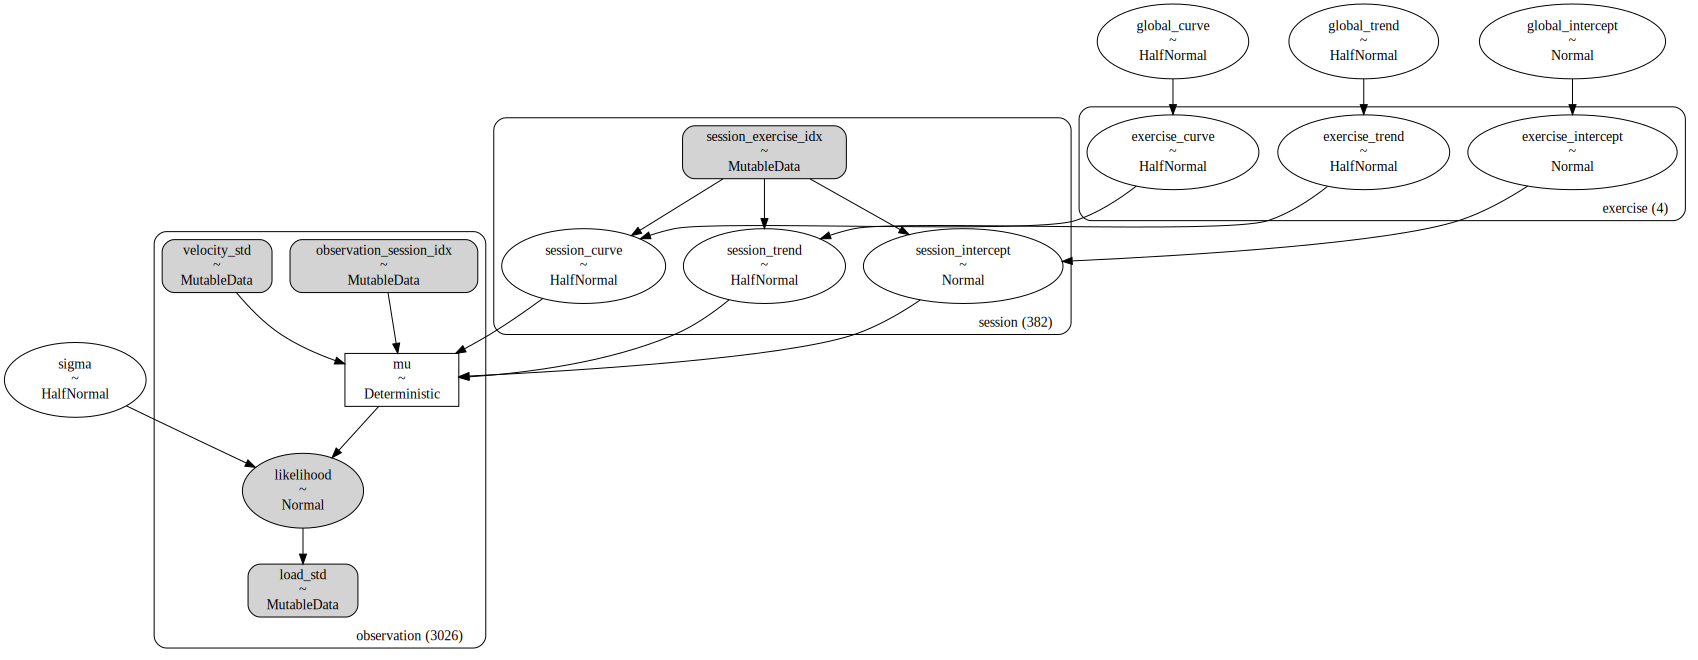

In [25]:
model = build_model(**model_data)

### Sample

In [26]:
pymc_inference_data = sample_pymc_nuts(model = model, target_accept = 0.9)

Sample posterior...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_intercept, global_trend, global_curve, exercise_intercept, exercise_trend, exercise_curve, session_intercept, session_trend, session_curve, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
Sampling: [exercise_curve, exercise_intercept, exercise_trend, global_curve, global_intercept, global_trend, likelihood, session_curve, session_intercept, session_trend, sigma]


Sample prior predictive...
Sample posterior predictive...


Sampling: [likelihood]


In [27]:
pymc_inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

### Generate Predictions

In [28]:
prediction_data = generate_prediction_data(train_data, velocity_standardizer)
prediction_data

,velocity,session,velocity_std,exercise,load_std,observation
0,1.60,2,3.117912,NaN,NaN,21548
1,1.59,2,3.086285,NaN,NaN,21549
2,1.58,2,3.054658,NaN,NaN,21550
3,1.57,2,3.023031,NaN,NaN,21551
4,1.56,2,2.991403,NaN,NaN,21552
...,...,...,...,...,...,...
61520,0.04,979,-1.815930,NaN,NaN,80042
61521,0.03,979,-1.847557,NaN,NaN,80043
61522,0.02,979,-1.879184,NaN,NaN,80044
61523,0.01,979,-1.910811,NaN,NaN,80045


In [29]:
with model:
    pm.set_data(new_data = {'velocity_std': prediction_data['velocity_std'],
                            'load_std': prediction_data['load_std'],
                            'observation_session_idx': session_encoder.transform(prediction_data['session'])},
                coords = {'observation': prediction_data['observation']})

    pm.sample_posterior_predictive(trace = pymc_inference_data,
                                   var_names = ['mu', 'likelihood'],
                                   model = model,
                                   predictions = True,
                                   extend_inferencedata = True)

Sampling: [likelihood]


In [30]:
pymc_inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

## Plot

### Pairs

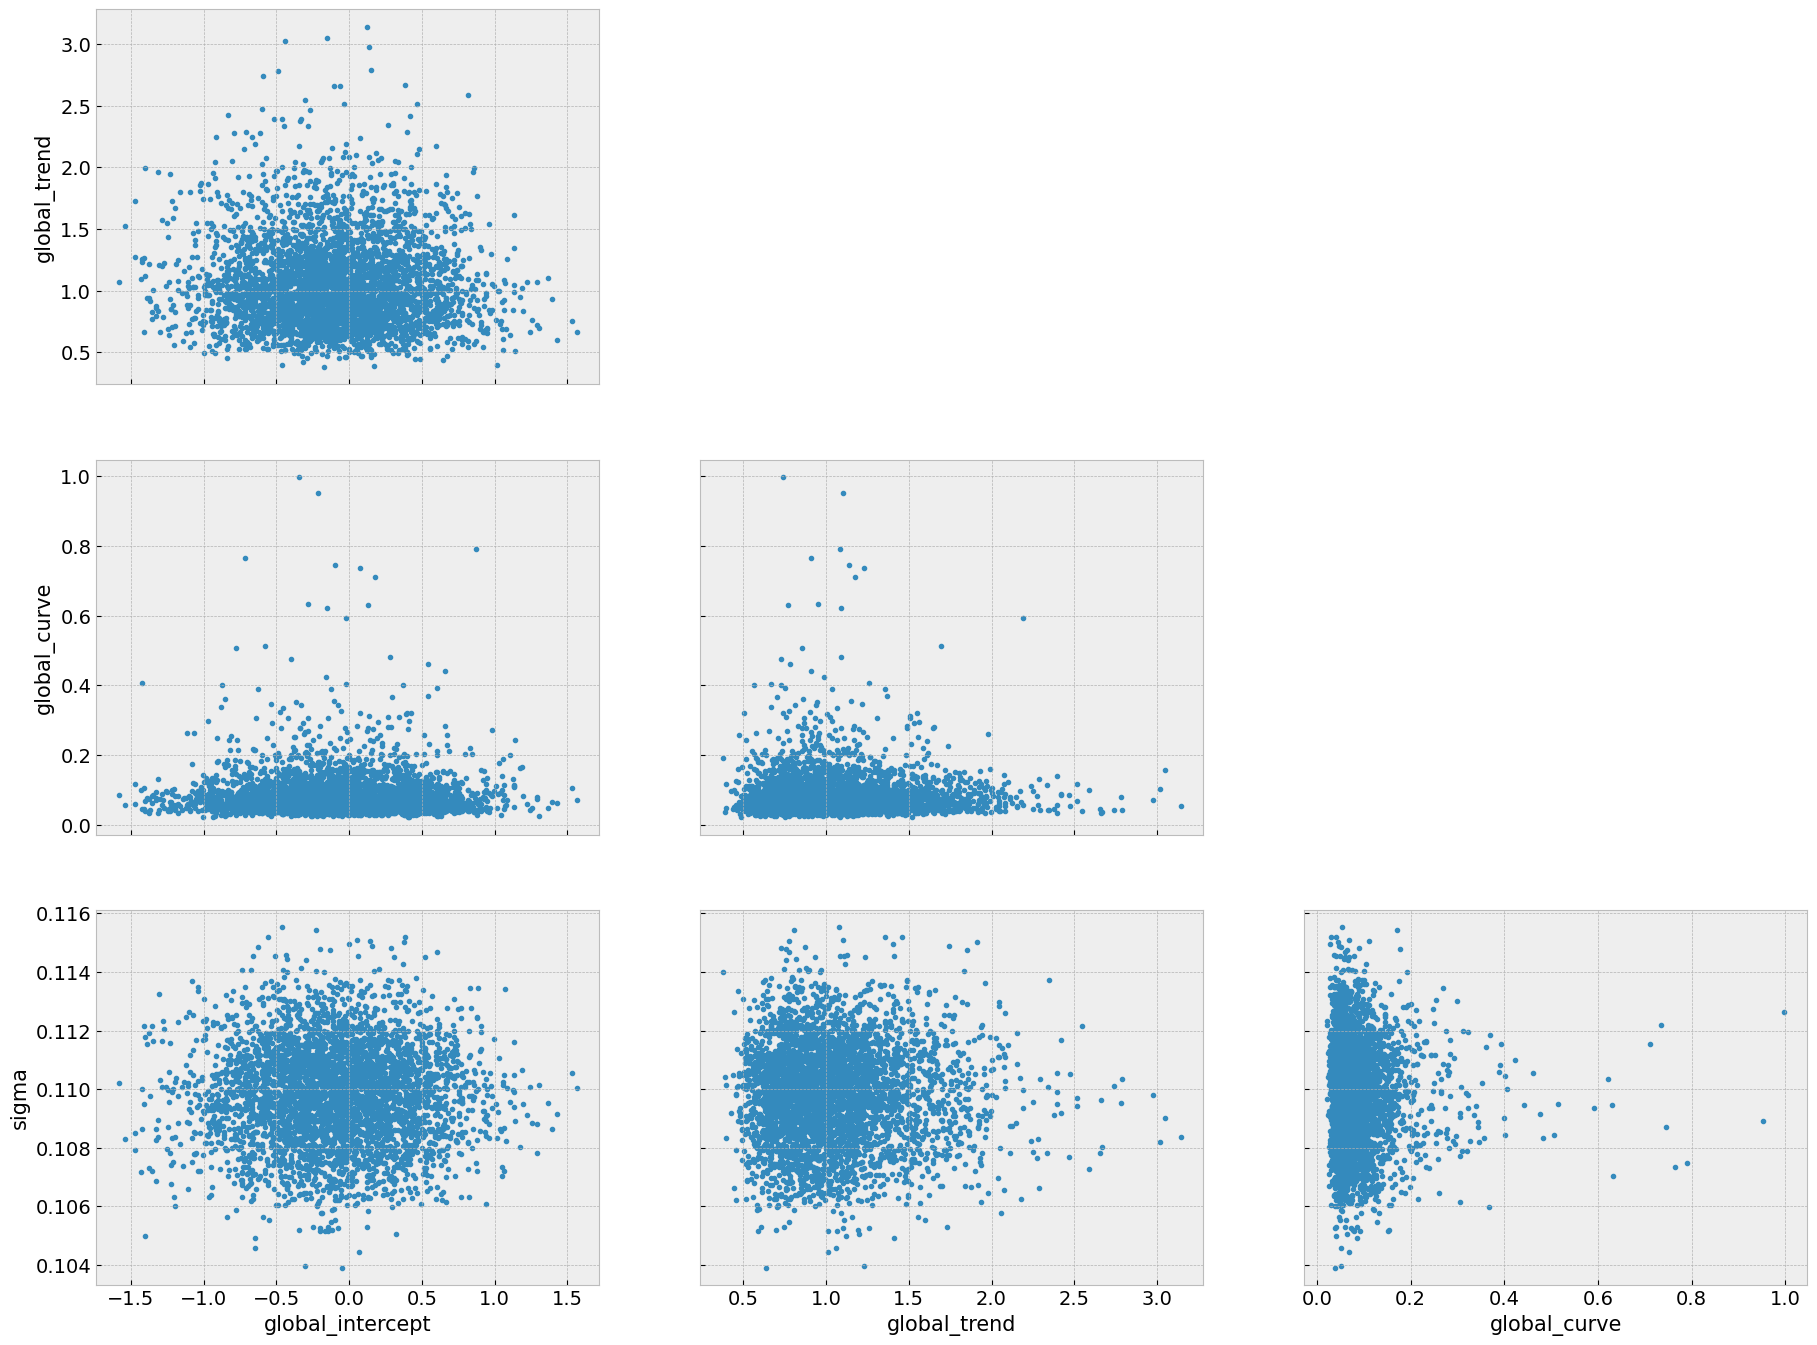

In [31]:
_ = az.plot_pair(pymc_inference_data,
                 var_names = ['global', 'sigma'],
                 filter_vars = 'like',
                 divergences = True)

### Trace

In [32]:
az.summary(pymc_inference_data,
           var_names = ['global', 'sigma', 'exercise'],
           filter_vars = 'like',
           hdi_prob = hdi_prob).sort_index()

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
exercise_curve[bench press],0.005,0.005,0.000,0.012,0.000,0.000,328.0,285.0,1.01
exercise_curve[deadlift],0.008,0.008,0.000,0.019,0.000,0.000,290.0,319.0,1.02
exercise_curve[overhead press],0.011,0.004,0.005,0.018,0.000,0.000,300.0,429.0,1.02
exercise_curve[squat],0.101,0.008,0.089,0.114,0.000,0.000,3413.0,3024.0,1.00
exercise_intercept[bench press],-0.941,0.164,-1.192,-0.655,0.002,0.001,9494.0,2554.0,1.00
exercise_intercept[deadlift],0.494,0.151,0.255,0.754,0.002,0.001,9308.0,2687.0,1.00
exercise_intercept[overhead press],-0.722,0.083,-0.853,-0.579,0.001,0.001,10442.0,2775.0,1.00
exercise_intercept[squat],0.655,0.079,0.529,0.786,0.001,0.001,9307.0,3278.0,1.00
exercise_trend[bench press],0.942,0.110,0.765,1.116,0.001,0.001,8749.0,2559.0,1.00
exercise_trend[deadlift],1.250,0.130,1.036,1.456,0.001,0.001,9219.0,2733.0,1.00


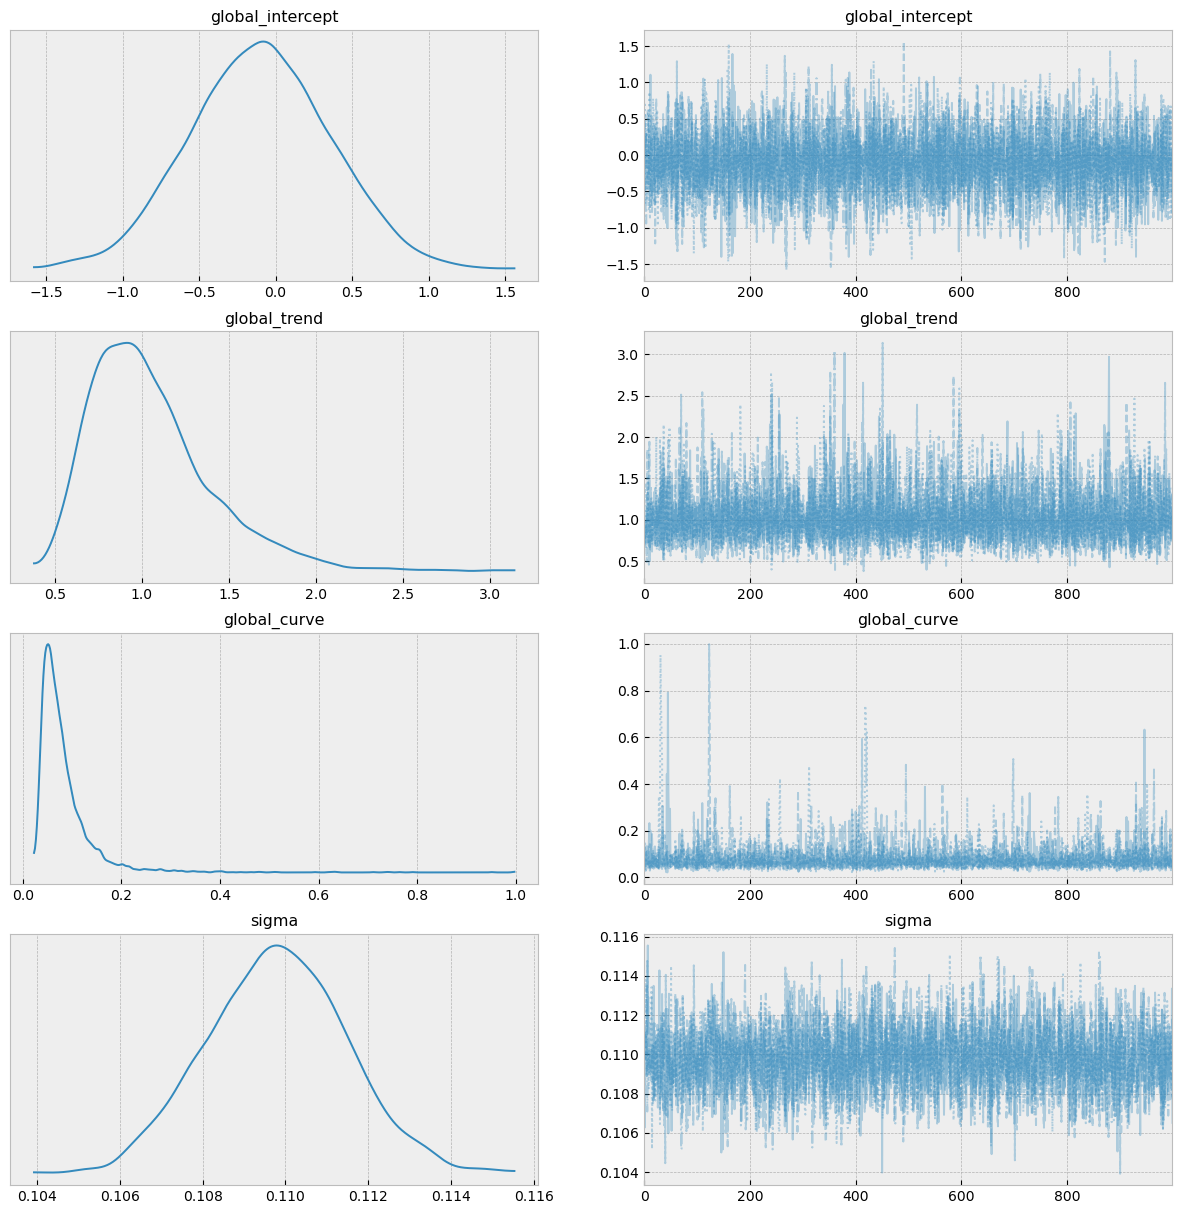

In [33]:
_ = az.plot_trace(pymc_inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 15],
                  var_names = ['global', 'sigma'],
                  filter_vars = 'like')

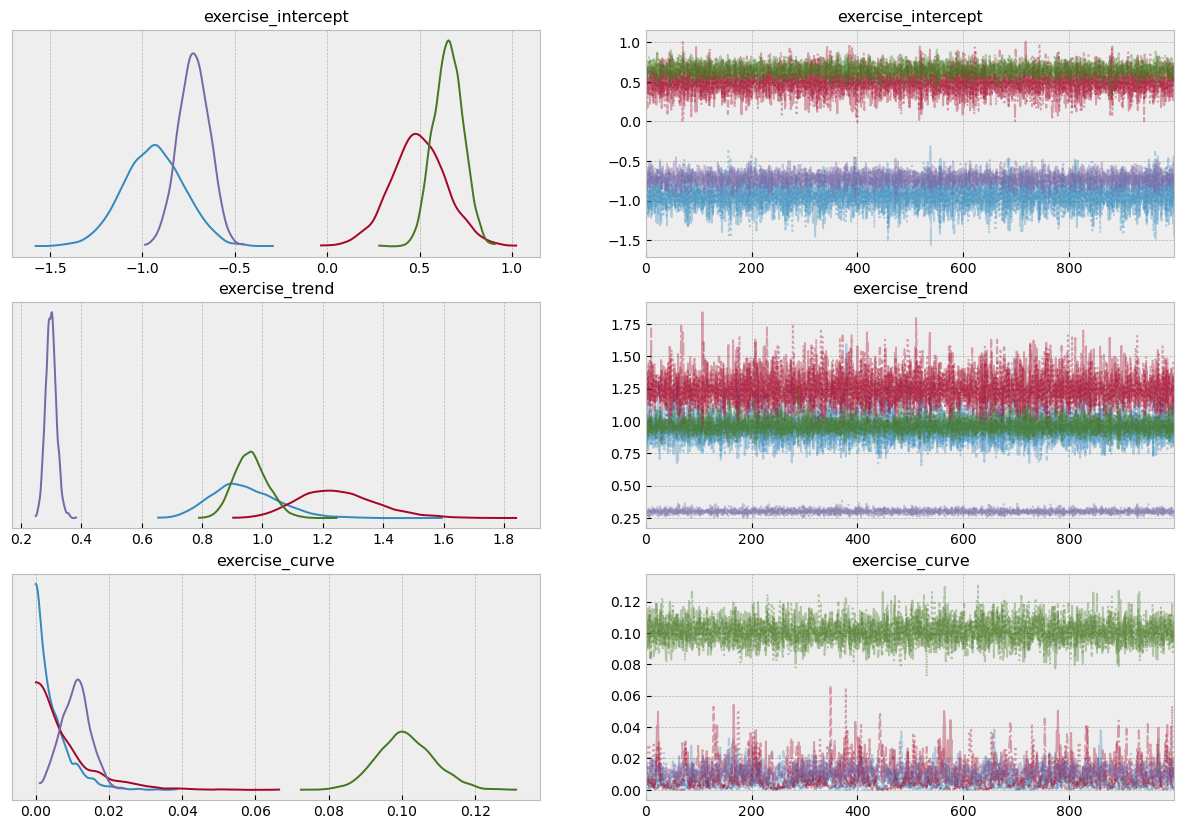

In [34]:
_ = az.plot_trace(pymc_inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 10],
                  var_names = ['exercise'],
                  filter_vars = 'like')

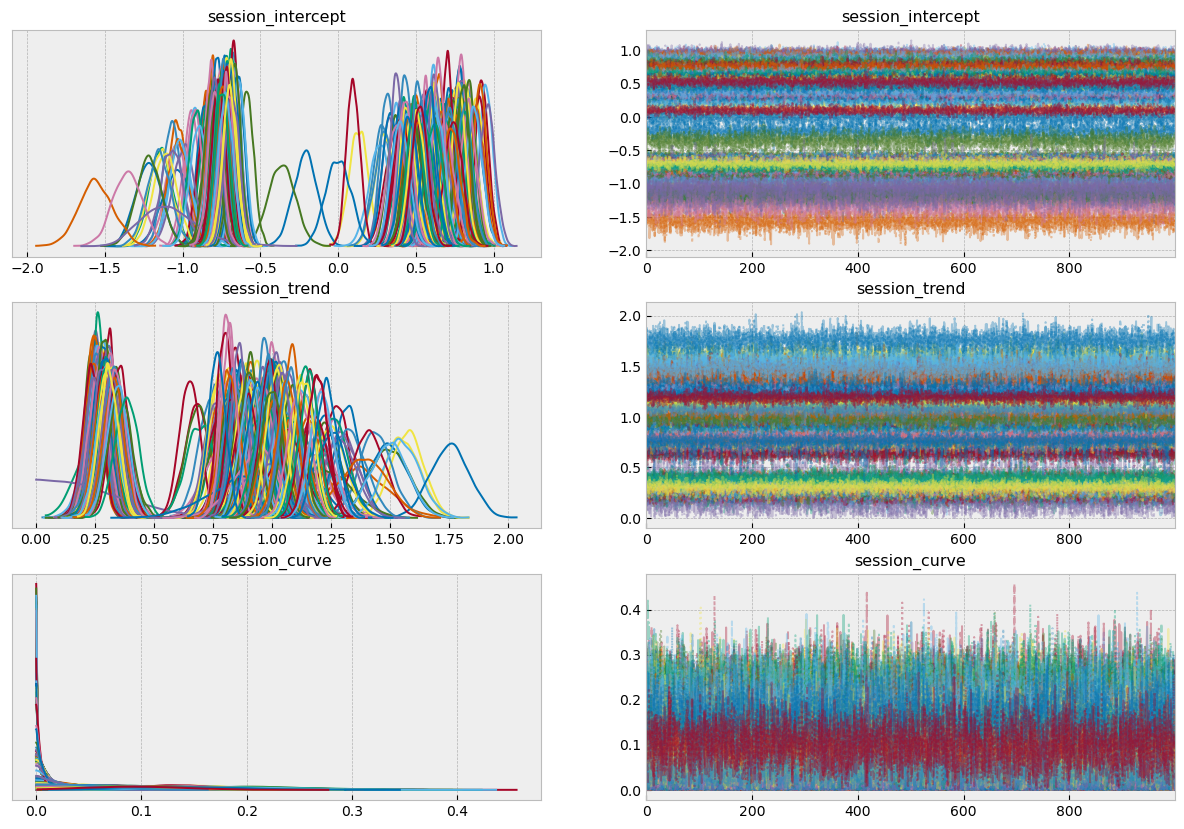

In [35]:
_ = az.plot_trace(pymc_inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 10],
                  var_names = ['session'],
                  filter_vars = 'like')

### Last Session Plot

/home/mattiasthalen/miniconda3/envs/pymc/lib/python3.10/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/home/mattiasthalen/miniconda3/envs/pymc/lib/python3.10/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/home/mattiasthalen/miniconda3/envs/pymc/lib/python3.10/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged neste

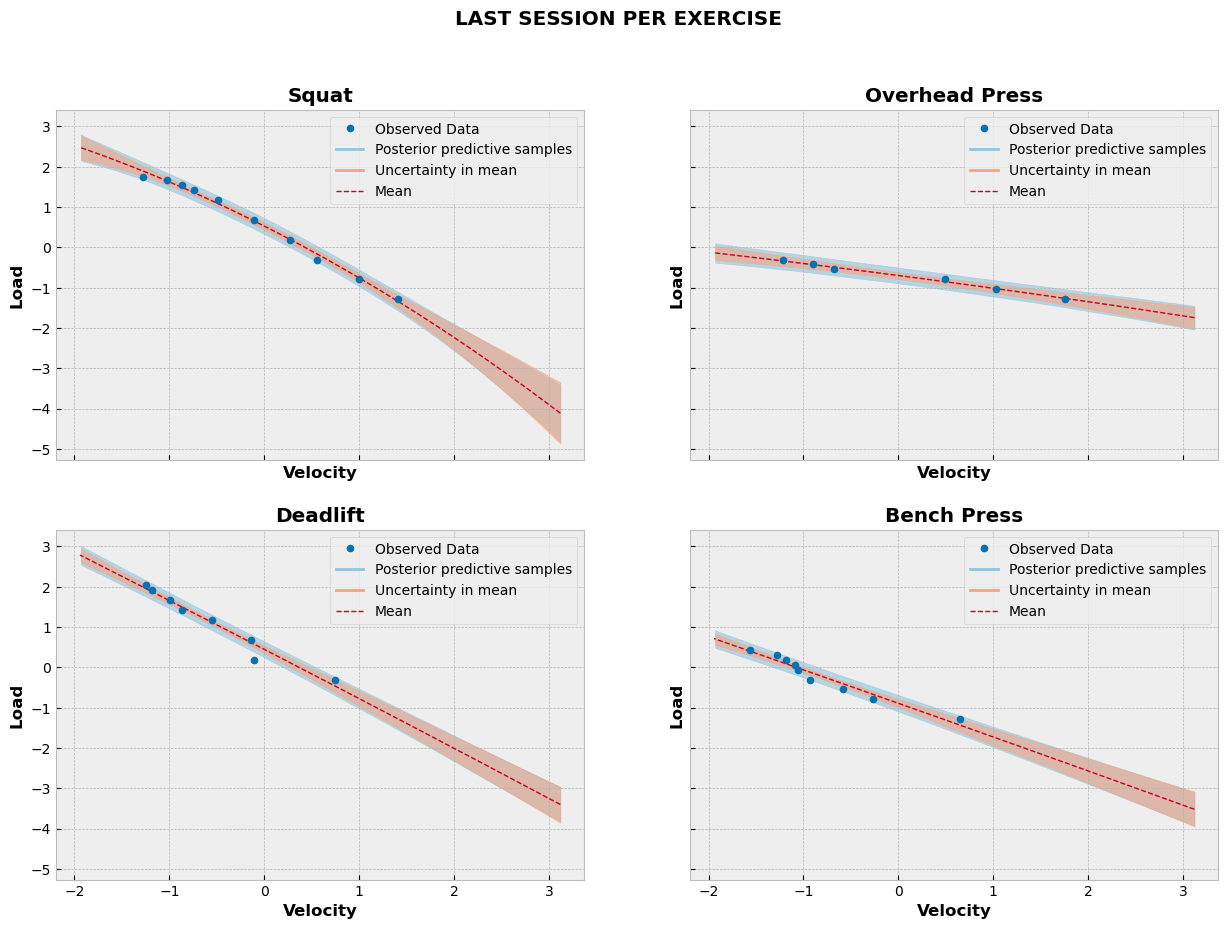

In [36]:
plot_last_session_predictions(inference_data = pymc_inference_data,
                              df = prediction_data,
                              exercises = ['squat', 'overhead press', 'deadlift', 'bench press'],
                              hdi_prob = hdi_prob)